# Spectral Density

## Load Libraries

In [1]:
from andbro__querrySeismoData import __querrySeismoData
from andbro__savefig import __savefig

from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm_notebook
from pathlib import Path

import os
import pickle
import matplotlib.pyplot as plt

In [2]:
from functions.get_hist_loglog import __get_hist_loglog

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [4]:
config = {}


config['d1'], config['d2'] = "2023-12-01", "2023-12-31"

config['path_to_data'] = data_path+f"LNM2/PSDS/"

config['outpath_figures'] = data_path+f"LNM2/figures/"

config['frequency_limits'] = 1e-3, 1e1


In [5]:
# ## ---------------------------------------

# # name, comp, app = "PROMY", "", ""
# # name, comp, app = "FFBI", "", "_absolute"
# # name, comp, app  = "ROMY", "Z", ""
# # name, comp, app = "ROMY", "U", ""
# # name, comp, app = "ROMY", "V", ""
# # name, comp, app = "FUR", "Z", ""
# # name, comp, app = "FUR", "N", ""
# name, comp, app = "FUR", "E", ""

# year = "2023"

# path = data_path+f"LNM2/PSDS/"

# t1 ,t2 = "2023-09-23", "2023-10-23"

In [6]:
# ## ---------------------------------------

# ## load configurations
# if len(comp) != 0:
#     config = pickle.load(open(path+name+app+"/"+f"{year}_{name}_{comp}_3600_config.pkl", 'rb'))
#     config['filename'] = f"{name}{app}/{year}_{name}_{comp}_3600"
#     config['station'] = f"{name}_{comp}"
# else:
#     config = pickle.load(open(path+name+app+"/"+f"{year}_{name}_3600_config.pkl", 'rb'))
#     config['filename'] = f"{name}{app}/{year}_{name}_3600"
#     config['station'] = f"{name}"


# config['path'] = path

# config['startdate'], config['enddate'] = t1, t2


# ## specify paths
# config['outpath_figures'] = data_path+f"LNM2/figures/"

# config['path_to_outdata'] = data_path+f"LNM2/data/"

## Methods

In [7]:
def __filter_psds(psds, thresholds):

    from numpy import mean, array

    psds_filtered = []
        ## filter mean psds values
#         m_psd = mean(psd)
#         if m_psd > thresholds[0] and m_psd < thresholds[1]:
#             psds_filtered.append(psd)

    ## filter for periods larger than 20 seconds
    if mean(psd[0:63]) < thresholds[0]:
        psds_filtered.append(psd)

    print(f" -> removed {len(psds)- len(psds_filtered)} of {len(psds)} psds due to thresholds: {thresholds[0]} & {thresholds[1]}")
    return array(psds_filtered)

In [8]:
def __cut_frequencies_array(arr, freqs, fmin, fmax):

    ind = []
    for i, f in enumerate(freqs):
        if f >= fmin and f <= fmax:
            ind.append(i)

    ff = freqs[ind[0]:ind[-1]]
    pp = arr[:,ind[0]:ind[-1]]

    return pp, ff

In [9]:
def __remove_noisy_psds(arr, threshold_mean=1e-16, ff=None, flim=None):

    from numpy import delete, shape, sort, array, ones, nan

    if flim is not None and ff is not None:
        for n, f in enumerate(ff):
            if f > flim:
                idx_max = n
                break

    idx_min = 5

    l1 = shape(arr)[0]

    idx_to_remove = []
    rejected = []
    for ii in range(shape(arr)[0]):

        ## appy upper threshold
        if flim is not None and ff is not None:
            if arr[ii, idx_min:idx_max].mean() > threshold_mean:
                if ii == 0:
                    print(f" -> filter threshold between {round(ff[idx_min],4)} and {round(ff[idx_max],2)}")
                rejected.append(arr[ii, :])
                arr[ii] = ones(len(arr[ii])) * nan
                # idx_to_remove.append(ii)
        else:
            if arr[ii, :].mean() > threshold_mean:
                rejected.append(arr[ii, :])
                idx_to_remove.append(ii)

        ## apply default lowe threshold
        if arr[ii, :].mean() < 1e-26:
            rejected.append(arr[ii, :])
            idx_to_remove.append(ii)

    # for jj in sort(array(idx_to_remove))[::-1]:
    #     arr = delete(arr, jj, axis=0)

    l2 = shape(arr)[0]

    print(f" -> removed {l1-l2} rows due to mean thresholds!")
    print(f" -> {l2} / {l1} psds remain")

    return arr, rejected

In [10]:
def __makeplot_colorlines(config, ff, psds, rejected, day):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)



    ##____________________________


    fig, axes = plt.subplots(1, 1, figsize=(15,7), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = 24
    colors = plt.cm.rainbow(linspace(0, 1, N))
    cmap = plt.get_cmap('rainbow', 24)

    for n, psd in enumerate(psds):
        axes.loglog(ff, psd, color=colors[n], alpha=0.7)
        p2 = axes.scatter(ff[0], psd[0], s=0.1, c=int(n/N), cmap=cmap, vmin=0, vmax=N)

    for reject in rejected:
         axes.loglog(ff, reject, color='grey', alpha=0.6, zorder=1)

    axes.loglog(ff, __get_median_psd(psds), 'black', zorder=3, alpha=0.6, label="Median")

    axes.grid(True, which="both", ls="-", alpha=0.5)
    axes.legend(loc='lower left')
    axes.tick_params(labelsize=font-2)

    axes.set_xlim(1e-3, 2e1)
#     axes.set_ylim(1e-23, 1e-16)

    axes.set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)


    # axes.set_ylabel(r"PSD$_{absolute}$ ($hPa$/$Hz)$", fontsize=font)
    axes.set_ylabel(r"PSD$_{infrasound}$ ($hPa$/$Hz)$", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes, aspect=50, pad=-1e-5,
                       ticks=arange(1,N,2))

    axes.set_title(f"{config['station']} | {day}")

    plt.show();
    return fig

In [11]:
def __makeplot_colorlines_overview(config, ff, psds, rejected, day):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)


    ## convert frequencies to periods
    pp=[]
    for mm in range(len(ff)):
        ppp = zeros(len(ff[mm]))
        ppp = 1/ff[mm]
        pp.append(ppp)


    ##____________________________

    NN = 3

    fig, axes = plt.subplots(NN,1, figsize=(10,10), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

#     N = max(psds[0].shape[0], psds[1].shape[0], psds[2].shape[0])
#     colors = plt.cm.rainbow(linspace(0, 1, N))

    N = 24
    colors = plt.cm.rainbow(linspace(0,1,N))
    cmap = plt.get_cmap('rainbow', 24)


    ## add Frequency Axis
#     g = lambda x: 1/x
#     ax2 = axes[0].secondary_xaxis("top", functions=(g,g))
#     ax2.set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)
#     ax2.set_xticklabels(ff[2], fontsize=11)
#     ax2.tick_params(axis='both', labelsize=font-2)


    for j in range(NN):
        for n, psd in enumerate(tqdm(psds[j])):
            axes[j].loglog(ff[j], psd, color=colors[n], alpha=0.7)
            p2 = axes[j].scatter(ff[j][0], psd[0], s=0., c=n/N, cmap=cmap, vmin=0, vmax=N)

        for reject in rejected[j]:
             axes[j].loglog(ff[j],reject, color='grey', alpha=0.6, zorder=1)

        axes[j].loglog(ff[j], __get_median_psd(psds[j]), 'black', zorder=3, alpha=0.6, label="Median")


        axes[j].grid(True, which="both", ls="-", alpha=0.5)
        axes[j].legend(loc='lower left')
        axes[j].tick_params(labelsize=font-2)


    axes[NN-1].set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)

    ## panel labels
    axes[0].text(.01, .99, 'a)', ha='left', va='top', transform=axes[0].transAxes, fontsize=font+2)
    axes[1].text(.01, .99, 'b)', ha='left', va='top', transform=axes[1].transAxes, fontsize=font+2)
    axes[2].text(.01, .99, 'c)', ha='left', va='top', transform=axes[2].transAxes, fontsize=font+2)

    axes[0].set_ylabel(r"PSD$_{vertical}$ (m$^2$/s$^4$/$Hz)$", fontsize=font)
    axes[1].set_ylabel(r"PSD$_{north}$ (m$^2$/s$^4$/$Hz)$", fontsize=font)
    axes[2].set_ylabel(r"PSD$_{east}$ (m$^2$/s$^4$/$Hz)$", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes.ravel().tolist(), aspect=50, pad=-1e-5,
                       ticks=arange(1,N,2))


    plt.show();
    return fig

## RUN for all files 

### Load PSD Files

In [12]:
def __read_files(seed, tbeg, tend):

    net, sta, loc, cha = seed.split('.')

    psds_medians_out, times_out = [], []

    dat, dates = [], []
    for jj, day in enumerate(date_range(tbeg, tend)):

        # if jj > 2:
        #     continue

        day = str(day).split(" ")[0].replace("-", "")

        filename = f"{sta}/{day[:4]}_{sta}_{cha}_3600_{day}_hourly.pkl"

        ## skip if file does not exist
        if not os.path.isfile(config['path_to_data']+filename):
            print(f" -> skipping {filename} ...")
            continue

        try:
            out = read_pickle(config['path_to_data']+filename)
            ff1, dat1 = out['frequencies'], out['psd']

        except Exception as e:
            print(e)
            print(f" -> {day}: no data found")
            continue

        for _k, _psd in enumerate(dat1):
            dat.append(_psd)
            dates.append(f"{day}_{str(_k).rjust(2, '0')}")

    dat = array(dat)

    return dat, ff1

In [13]:
# fur_z, ff_z = __read_files("GR.FUR..BHZ", config['d1'], config['d2'])
# fur_n, ff_n = __read_files("GR.FUR..BHN", config['d1'], config['d2'])
# fur_e, ff_e = __read_files("GR.FUR..BHE", config['d1'], config['d2'])

romy_z, ff_z = __read_files("BW.ROMY..BJZ", config['d1'], config['d2'])
romy_n, ff_n = __read_files("BW.ROMY..BJN", config['d1'], config['d2'])
romy_e, ff_e = __read_files("BW.ROMY..BJE", config['d1'], config['d2'])

ffbi_f, ff_f = __read_files("BW.FFBI..BDF", config['d1'], config['d2'])
ffbi_o, ff_o = __read_files("BW.FFBI..BDO", config['d1'], config['d2'])

In [14]:
romy_z, _ = __remove_noisy_psds(romy_z, threshold_mean=1e-18, ff=ff_z, flim=0.05)
romy_n, _ = __remove_noisy_psds(romy_n, threshold_mean=1e-18, ff=ff_n, flim=0.05)
romy_e, _ = __remove_noisy_psds(romy_e, threshold_mean=1e-18, ff=ff_e, flim=0.05)

 -> filter threshold between 0.0007 and 0.05
 -> removed 0 rows due to mean thresholds!
 -> 744 / 744 psds remain
 -> filter threshold between 0.0007 and 0.05
 -> removed 0 rows due to mean thresholds!
 -> 744 / 744 psds remain
 -> filter threshold between 0.0007 and 0.05
 -> removed 0 rows due to mean thresholds!
 -> 744 / 744 psds remain


### Compute Histograms

In [15]:
def __get_hist_loglog(psd_array, ff, bins=20, density=False, axis=1, plot=False):

    import matplotlib.pyplot as plt
    from numpy import argmax, std, median, isnan, array, histogram, nan, zeros, count_nonzero, isinf, log10, nanmax, nanmin, nonzero
    from scipy.stats import median_abs_deviation as mad

    def __convert_to_log(in_psds):

        out_psds = zeros(in_psds.shape)
        rows_with_zeros = 0

        for i, psd in enumerate(in_psds):
            if count_nonzero(psd) != len(psd):
                rows_with_zeros += 1
                psd = [nan for val in psd if val == 0]
            out_psds[i, :] = log10(psd)
            if isinf(out_psds[i,:]).any():
                out_psds[i, :] = nan * ones(len(out_psds[i, :]))

        print(f" -> rows with zeros: {rows_with_zeros}")

        return out_psds

    ## converting to log10
    psd_array = __convert_to_log(psd_array)

    ## exclude psds with only NaN values
    psds = array([psd for psd in psd_array if not isnan(psd).all()])
    print(f" -> total spectra used: {psd_array.shape[0]}")

    ## find overall minimum and maxium values
    # max_value = max([max(sublist) for sublist in psd_array])
    # min_value = min([min(sublist) for sublist in psd_array])
    max_value = nanmax(psd_array.reshape(psd_array.size))
    min_value = nanmin(psd_array.reshape(psd_array.size))
    # print(min_value, max_value)

    ## define empty lists
    dist, dist_maximas, bins_maximas, bins_medians, stds, mads = [], [], [], [], [], []

    count = 0
    for h in range(len(psd_array[axis])):

        psd = psd_array[:, h]

        ## compute histograms
        hist, bin_edges = histogram(psd, bins=bins, range=(min_value, max_value), density=density);

        ## center bins
        bin_mids = 0.5*(bin_edges[1:] + bin_edges[:-1])

        ## normalization
#         if True:
#             hist = [val / len(psd_array[:,h]) for val in hist]
#             config['set_density'] = True

        ## check if density works
        # DX = abs(max_value-min_value)/bins
        # SUM = sum(hist)
        # if str(SUM*DX) != "1.0":
        #     count += 1

        ## modify histogram with range increment
        # hist = hist*DX
        hist = [h / sum(hist) for h in hist]


        ## append values to list
        dist.append(hist)
        stds.append(std(hist))
        dist_maximas.append(max(hist))
        bins_maximas.append(bin_mids[argmax(hist)])
        mads.append(mad(hist))

        ## compute median
        psd = psd[~(isnan(psd))]
        bins_medians.append(median(psd[psd != 0]))

    ## undo log conversion
    output = {}
    output['dist'] = array(dist)
    output['bin_mids'] = 10**array(bin_mids)
    output['bins_maximas'] = 10**array(bins_maximas)
    output['stds'] = 10**array(stds)
    output['mads'] = 10**array(mads)
    output['bins_medians'] = 10**array(bins_medians)
    output['set_density'] = density
    output['total'] = psd_array.shape[0]
    output['frequencies'] = ff


    ## check plot
    if plot:

        fig = plt.figure(figsize=(15, 5))
        cmap = plt.colormaps.get_cmap('viridis')
        cmap.set_under(color='white')

        _tmp = output['dist'].reshape(output['dist'].size)
        cb = plt.pcolormesh(ff, output['bin_mids'], output['dist'].T, cmap=cmap, shading="auto",
                            rasterized=True, antialiased=True, vmin=min(_tmp[nonzero(_tmp)]), norm="log")

        plt.yscale("log")
        plt.xscale("log")

        plt.colorbar(cb)

        plt.xlabel("Frequency (Hz)")
        plt.ylabel("PSD")

        plt.xlim(ff[1], ff[-1])

        plt.show();

    if count > 0:
        print(f" -> {count}/{len(psd_array[axis])} errors found for density computation!!!")

    return output

 -> rows with zeros: 0
 -> total spectra used: 744


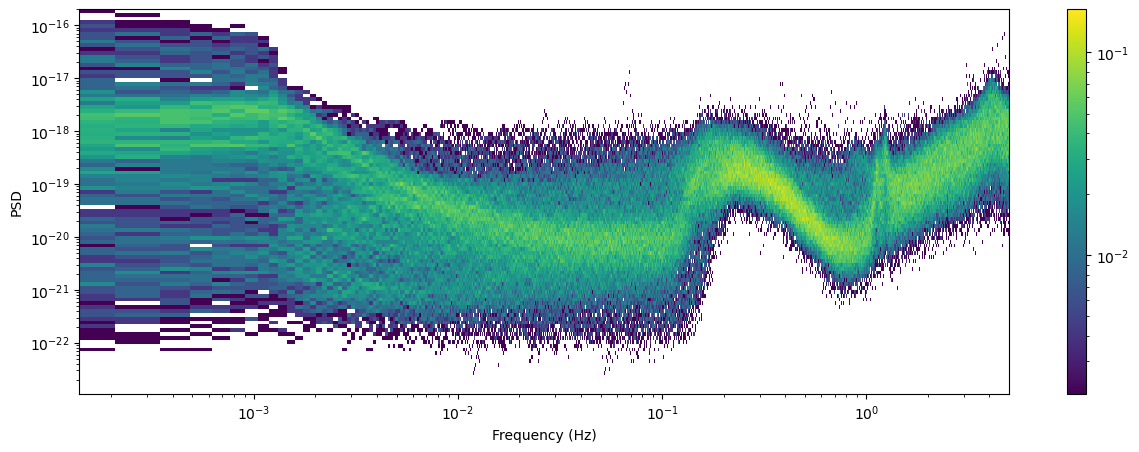

 -> rows with zeros: 0
 -> total spectra used: 744


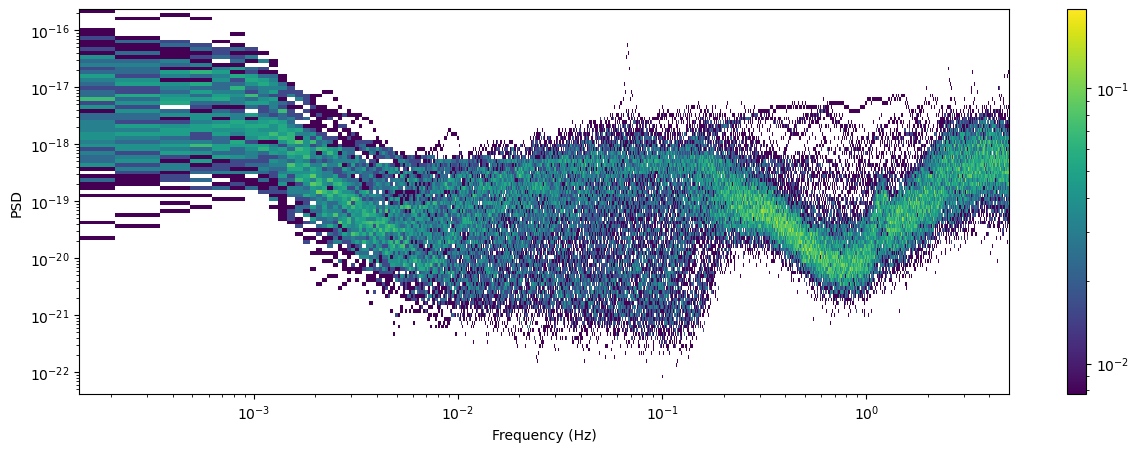

 -> rows with zeros: 0
 -> total spectra used: 744


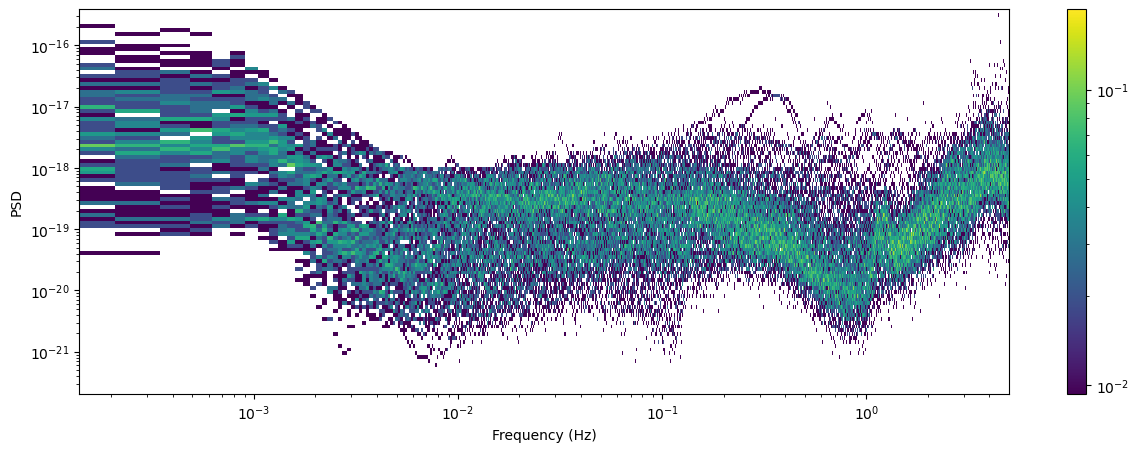

 -> rows with zeros: 0
 -> total spectra used: 744


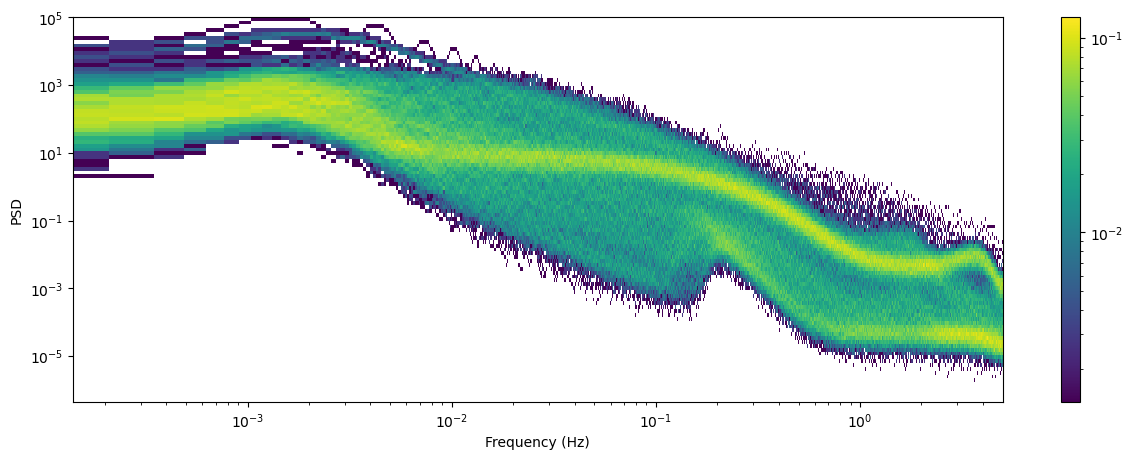

 -> rows with zeros: 0
 -> total spectra used: 744


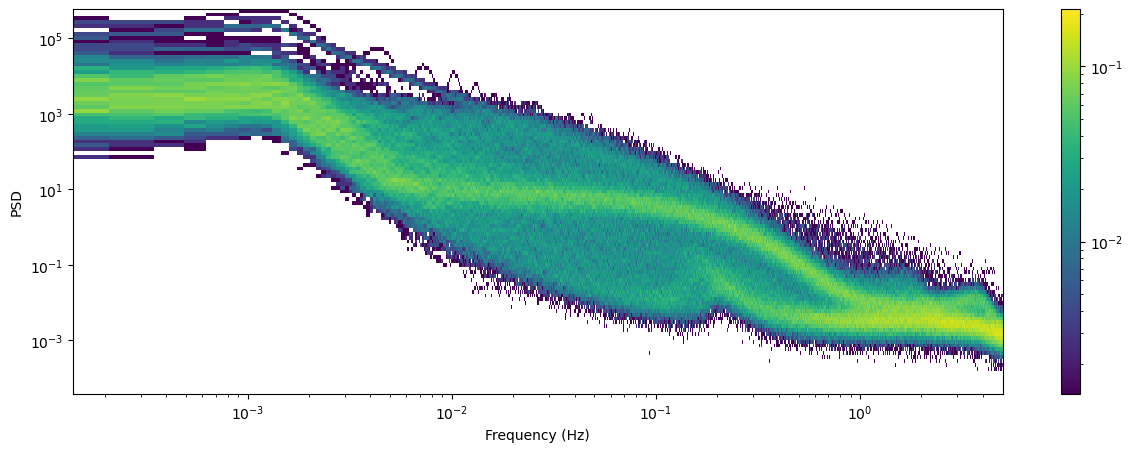

In [16]:
# out_fur_z = __get_hist_loglog(fur_z, ff_z, bins=100, density=False, axis=1, plot=True)
# out_fur_n = __get_hist_loglog(fur_n, ff_n, bins=100, density=False, axis=1, plot=True)
# out_fur_e = __get_hist_loglog(fur_e, ff_e, bins=100, density=False, axis=1, plot=True)

out_romy_z = __get_hist_loglog(romy_z, ff_z, bins=100, density=False, axis=1, plot=True)
out_romy_n = __get_hist_loglog(romy_n, ff_n, bins=100, density=False, axis=1, plot=True)
out_romy_e = __get_hist_loglog(romy_e, ff_e, bins=100, density=False, axis=1, plot=True)

out_ffbi_f = __get_hist_loglog(ffbi_f, ff_f, bins=100, density=False, axis=1, plot=True)
out_ffbi_o = __get_hist_loglog(ffbi_o, ff_o, bins=100, density=False, axis=1, plot=True)

## Plotting

In [17]:
def __makeplot_density(data, name="FUR"):

    import matplotlib.pyplot as plt
    import numpy as np


    def __get_median_psd(psds):

        from numpy import median, zeros, isnan

        med_psd = zeros(psds.shape[1])

        for f in range(psds.shape[1]):
            a = psds[:, f]
            med_psd[f] = median(a[~isnan(a)])

        return med_psd


    # psd_median = __get_median_psd(dat)


    font = 12

    Nrow, Ncol = len(data), 1

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 10), sharex=True)


    ## theoretical rlnm
    # plt.plot(periods, rlnm_psd, color="black", zorder=2, lw=2, ls="--", label="RLNM")

    for _n, out in enumerate(data):

        out['dist'] = np.ma.masked_array(out['dist'], out['dist'] == 0)

        y_axis = 10**(out['bin_mids']/10)

        x_axis = out['frequencies']

        if x_axis[_n] == 0:
            x_axis[_n] == 1e-20

        ## plotting

        cmap = plt.colormaps.get_cmap('viridis')
        # cmap.set_under(color='white')

        _tmp = out['dist'].reshape(out['dist'].size)

        im = ax[_n].pcolormesh(out['frequencies'], out['bin_mids'], out['dist'].T,
                               cmap=cmap, shading="auto", antialiased=True, rasterized=True,
                               vmin=min(_tmp[np.nonzero(_tmp)]), zorder=2, norm="log")

        ax[_n].set_xscale("log")
        ax[_n].set_yscale("log")
        ax[_n].tick_params(axis='both', labelsize=font-1)
        ax[_n].set_xlim(1e-3, 2e0)
        ax[_n].grid(axis="both", which="both", ls="--", zorder=1)

        if name == "FUR":
            ax[_n].set_ylim(1e-20, 1e-10)
        elif name == "ROMY":
            ax[_n].set_ylim(1e-26, 1e-16)

        ax[Nrow-2].set_ylim(1e-5, 1e7)
        ax[Nrow-1].set_ylim(1e-5, 1e7)


    ax[Nrow-1].set_xlabel("Frequency (Hz)", fontsize=font)

    if name == "FUR":
        ax[0].set_ylabel(r"PSD ($m^2 /s^4 /Hz$)", fontsize=font)
        ax[1].set_ylabel(r"PSD ($m^2 /s^4 /Hz$)", fontsize=font)
        ax[2].set_ylabel(r"PSD ($m^2 /s^4 /Hz$)", fontsize=font)

    elif name == "ROMY":
        ax[0].set_ylabel(r"PSD ($rad^2 /s^2 /Hz$)", fontsize=font)
        ax[1].set_ylabel(r"PSD ($rad^2 /s^2 /Hz$)", fontsize=font)
        ax[2].set_ylabel(r"PSD ($rad^2 /s^2 /Hz$)", fontsize=font)

    ax[Nrow-2].set_ylabel(r"PSD ($Pa^2 /Hz$)", fontsize=font)
    ax[Nrow-1].set_ylabel(r"PSD ($Pa^2 /Hz$)", fontsize=font)

    ## add labels
    ax[0].text(.99, .95, f'{name}.Z', color="k", ha='right', va='top', transform=ax[0].transAxes, fontsize=font, bbox={'facecolor':'w', 'alpha':0.7, 'pad':2})
    ax[1].text(.99, .95, f'{name}.N', color="k", ha='right', va='top', transform=ax[1].transAxes, fontsize=font, bbox={'facecolor':'w', 'alpha':0.7, 'pad':2})
    ax[2].text(.99, .95, f'{name}.E', color="k", ha='right', va='top', transform=ax[2].transAxes, fontsize=font, bbox={'facecolor':'w', 'alpha':0.7, 'pad':2})
    ax[3].text(.99, .95, f'FFBI.O', color="k", ha='right', va='top', transform=ax[3].transAxes, fontsize=font, bbox={'facecolor':'w', 'alpha':0.7, 'pad':2})
    ax[4].text(.99, .95, f'FFBI.F', color="k", ha='right', va='top', transform=ax[4].transAxes, fontsize=font, bbox={'facecolor':'w', 'alpha':0.7, 'pad':2})

    ## add colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.02, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im, cax=cbar_ax)
    cb.set_label("Propability Density", fontsize=font, labelpad=-45, color="white")

    plt.show();
    return fig

/tmp/ipykernel_484418/3338735882.py:37: RuntimeWarning: overflow encountered in power
  y_axis = 10**(out['bin_mids']/10)


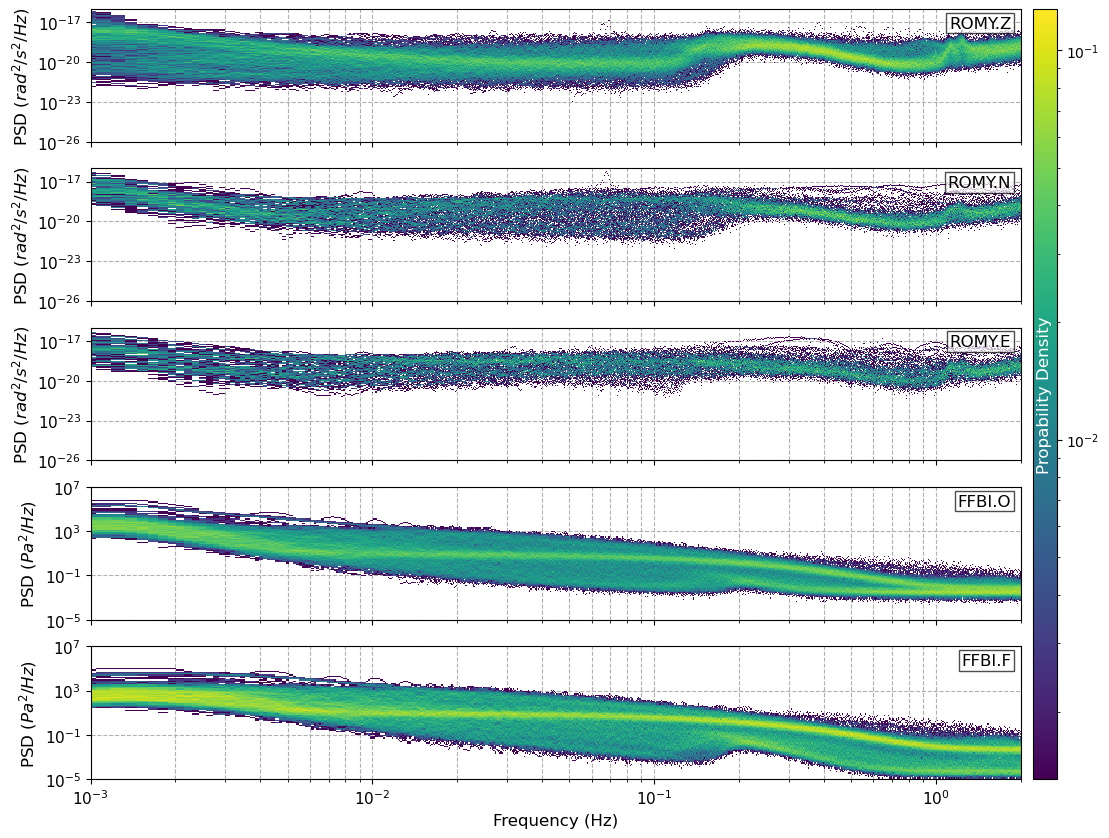

In [18]:
# name = "FUR"
# fig = __makeplot_density([out_fur_z, out_fur_n, out_fur_e, out_ffbi_o, out_ffbi_f], name=name)

name = "ROMY"
fig = __makeplot_density([out_romy_z, out_romy_n, out_romy_e, out_ffbi_o, out_ffbi_f], name=name)

fig.savefig(config['outpath_figures']+f"SpectraDensity_{name}_all.png", format="png", dpi=200, bbox_inches='tight')


## Get median and store

In [19]:
# psd_median = __get_median_psd(dat)

# out_df = DataFrame()
# out_df['psds_median'] = psd_median
# out_df['frequencies'] = ff

# out_df.to_pickle(config['path_to_outdata']+f"{year}_{name}_{comp}_psd_median.pkl")